# Text Mining Project - Stock Sentiment

## *Predicting market behavior from tweets*

### Group 42

Carolina Pinto - 20240494 <br>
Fábio dos Santos - 20240678 <br>
Guilherme – 2024 <br>
Mariana – 2024 <br>

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
   - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Data Exploration](#4-data-exploration)
   - [4.1. Class Distribution](#41-class-distribution)
   - [4.2. Text Length](#42-text-length)
   - [4.3. Data Manipulation for Further Exploration](#43-data-manipulation-for-further-exploration)
   - [4.4. Most Frequent Words per Label](#44-most-frequent-words-per-label)
   - [4.5. Word Cloud by Label](#45-word-cloud-by-label)
- [5. Corpus Split](#5-corpus-split)
- [6. Data Preprocessing](#6-data-preprocessing)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Classification Models](#8-classification-models)
- [9. Evaluation](#9-evaluation)

# 1. Import libraries

`Step 1` Import the required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import string

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Fábio Dos
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Fábio Dos
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Fábio Dos
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Data Integration

`Step 2` Import the dataset __train.csv__ using the method **read_csv()** from pandas.

In [2]:
df = pd.read_csv('../Project_Data/train.csv')

## 2.1. Data Description

`text`: tweets content. <br>
`label`: sentimental label, it can be bearish (0), bullish (1) or neutral (2).

# 3. Data Content

`Step 3` Check the first 5 rows of the dataset.

In [3]:
df.head(20)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


`Step 4` Check the number of rows and columns of the data frame.

In [4]:
df.shape

(9543, 2)

`Step 5` Check the features data types and info.

In [5]:
df.dtypes

text     object
label     int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Conclusions
- Our data is composed of **9543** observations and **2** columns. <br>
- Variable text is object and variable label is an integer as expected. <br>
- There are no null values in the observations. <br>
- Our tweets have a lot of "noise" letters and symbols like hashtags, dollar signs, links, punctuation and numbers. This should be adressed later on.

# 4. Data Exploration

`Step 6` Defining the colors to use in our visualizations for consistent representation (NOVA IMS official colors).

In [7]:
color_390 = (190/255, 214/255, 47/255)  # Pantone 390 C
color_431 = (92/255, 102/255, 108/255)  # Pantone 431 C

## 4.1. Class Distribution

`Step 7` Check Class Distribution (plot and percentage).

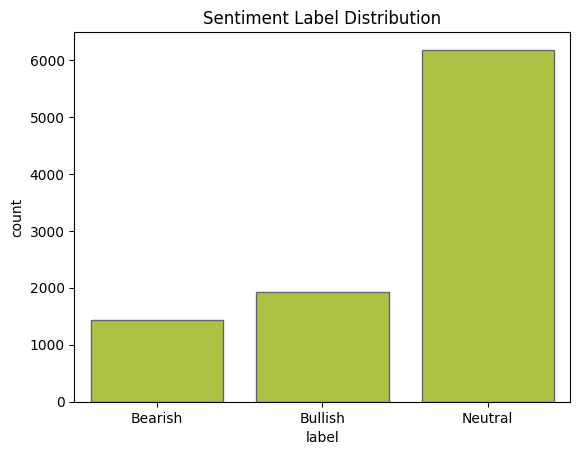

label
2    64.738552
1    20.150896
0    15.110552
Name: proportion, dtype: float64


In [8]:
sns.countplot(data=df, x='label', color=color_390, edgecolor=color_431)
plt.title("Sentiment Label Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

print(df['label'].value_counts(normalize=True) * 100)

- We can see that our labels are unbalanced, more than 60% is classified as "Neutral", 20% as "Bullish" and 15% as "Bearish".

## 4.2. Text Length

`Step 8` Check Text Length of the tweets per label.

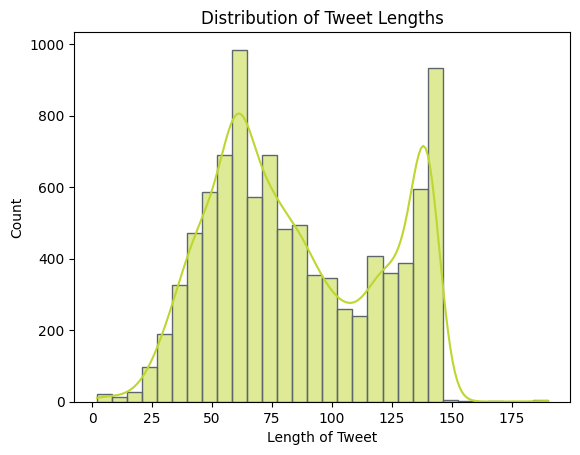

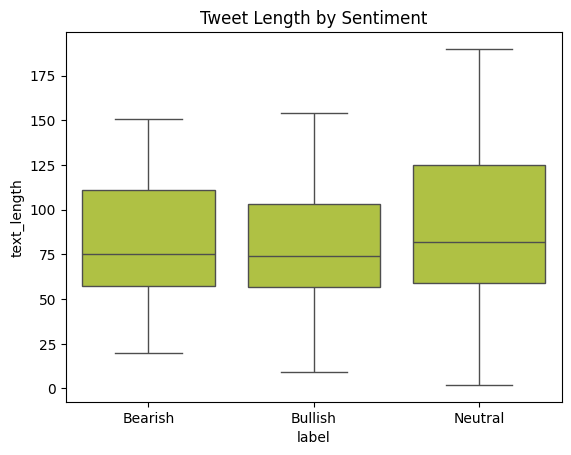

In [9]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], bins=30, kde=True, color=color_390, edgecolor=color_431)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet")
plt.show()

# Grouped by label
sns.boxplot(data=df, x='label', y='text_length', color=color_390)
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.title("Tweet Length by Sentiment")
plt.show()

- The different labels have a simillar distribution in terms of tweet length. <br>
- The tweets length are distributed in a normal distribution with two peaks at length between 60-65 and 140-145. <br> 
- There are a lot of tweets (approximately 1000) with length between 60-65, and around 900 with length between 140-145. This represents approximately 19% of the data. 

## 4.3. Data Manipulation for Further Exploration

- We want to check the most frequent words per label and the word clouds for each label. At this point our data is raw and we wouldn't get significant analysis. <br>
- For that reason in this section we will copy our dataset in order to do a small preprocessing (tokenize) and then perform the desired analysis. <br>
- After this data manipulation and the referred two analysis we will continue our work with corpus split and data preprocessing from the original dataset.

`Step 9` Using a copy of our dataset we tokenize the tweets in order to have a more accurate analysis.

In [10]:
df_copy = deepcopy(df)

stop_words = set(stopwords.words('english'))

# Preprocessing: basic cleaning and tokenization
def clean_and_tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)  
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

df_copy['tokens'] = df_copy['text'].apply(clean_and_tokenize)

df_copy

,text,label,text_length,tokens
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77,"[bynd, jpmorgan, reels, expectations, beyond, ..."
1,$CCL $RCL - Nomura points to bookings weakness...,0,102,"[ccl, rcl, nomura, points, bookings, weakness,..."
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94,"[cx, cemex, cut, credit, suisse, jp, morgan, w..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59,"[ess, btig, research, cuts, neutral]"
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71,"[fnko, funko, slides, piper, jaffray, pt, cut]"
...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136,"[weeks, gainers, losers, stoxx, europe, dec, e..."
9539,Tupperware Brands among consumer gainers; Unil...,2,67,"[tupperware, brands, among, consumer, gainers,..."
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89,"[vtv, therapeutics, leads, healthcare, gainers..."
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47,"[work, xpo, pyx, amkr, among, hour, movers]"


## 4.4. Most Frequent Words per Label

`Step 10` Check top 10 most frequent words per label. 


Top 10 words for Bearish tweets:
stock: 148
us: 99
misses: 85
coronavirus: 79
oil: 78
economy: 68
market: 66
stocks: 64
price: 64
china: 63


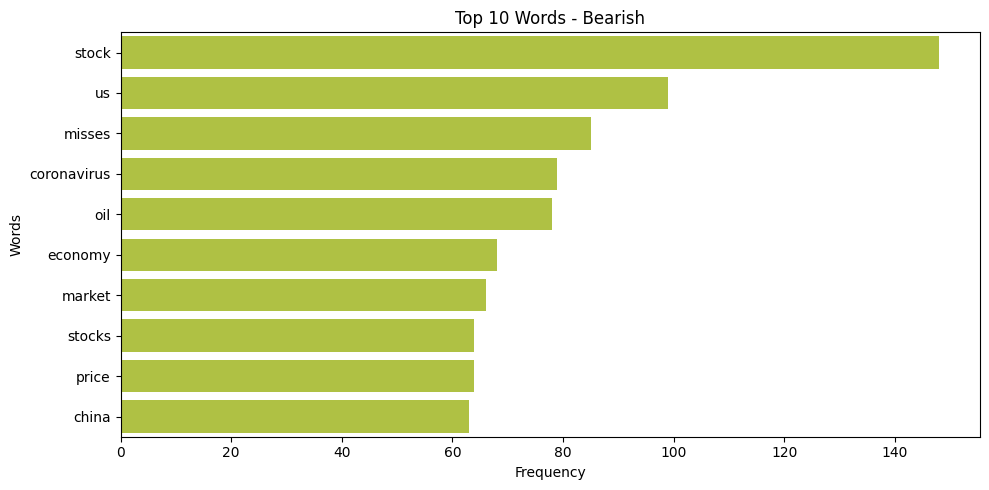


Top 10 words for Bullish tweets:
stock: 255
beats: 164
price: 137
us: 120
target: 117
stocks: 114
shares: 112
revenue: 106
market: 101
new: 97


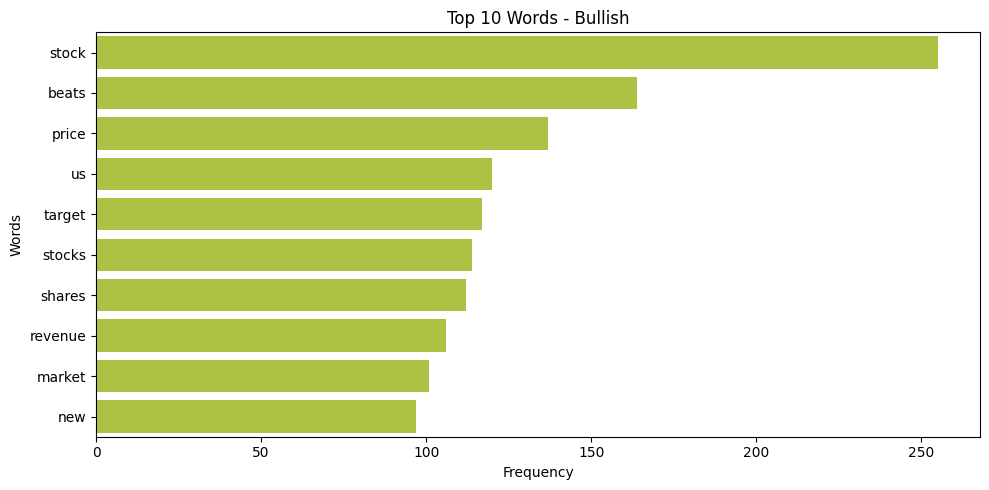


Top 10 words for Neutral tweets:
stock: 570
marketscreener: 376
results: 315
new: 285
earnings: 256
us: 233
says: 233
dividend: 225
reports: 222
inc: 195


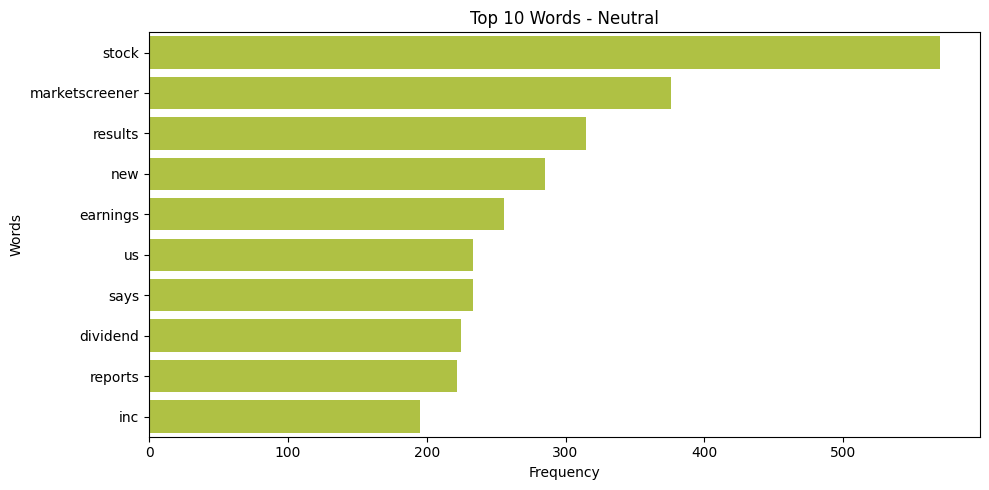

In [11]:
# Map labels to names
label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Show top 10 words per label
def get_top_words(df, label, top_n=10):
    all_words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
    most_common = Counter(all_words).most_common(top_n)

    print(f"\nTop {top_n} words for {label_names[label]} tweets:")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), color=color_390)
    plt.title(f"Top {top_n} Words - {label_names[label]}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Loop through each label
for label in sorted(df_copy['label'].unique()):
    get_top_words(df_copy, label, top_n=10)

In [12]:
df_copy.text_length.describe()

count    9543.000000
mean       85.858325
std        35.138568
min         2.000000
25%        58.000000
50%        79.000000
75%       120.000000
max       190.000000
Name: text_length, dtype: float64

- All three labels have the same most common word as "stock" but also a good amount of the plural "stocks". <br>
- "us" also have a good representation in all the 3 labels. <br>
- Even though there is a significance difference between labels there are still some common words between them. <br>
- Neutral tweets don't have such a big gap between the top 5 most common words, which makes the words distribution more balanced. <br>
- The largest tweet have 190 words while the smallest one have 2. <br>
- In average the tweets have around 79 words. 

## 4.5. Word Cloud by Label

`Step 11` Check Word Cloud of the different labels.

Word cloud for Bearish label:


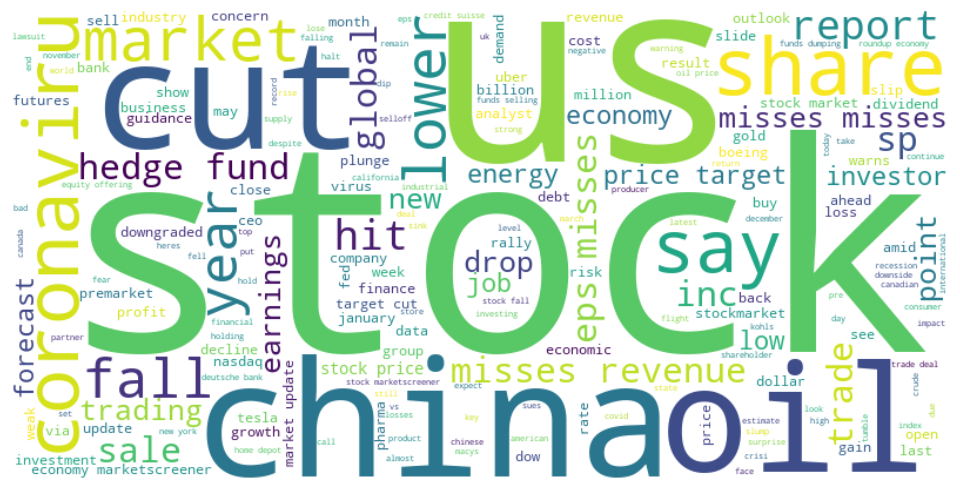

Word cloud for Bullish label:


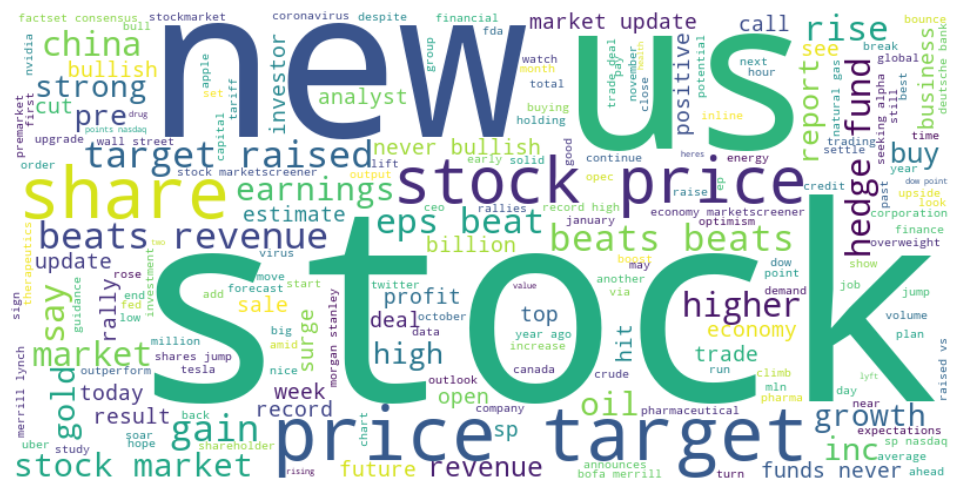

Word cloud for Neutral label:


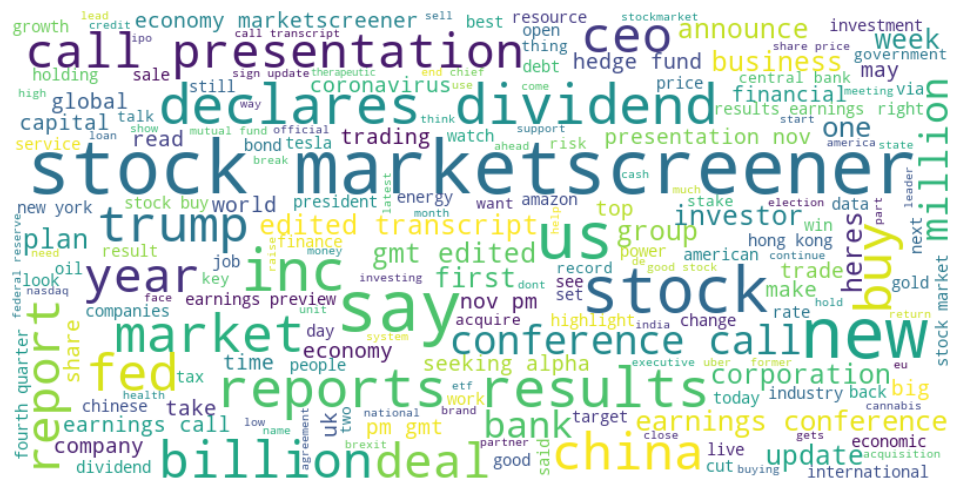

In [13]:
def plot_wordcloud(df, label, label_names):
    # Combine all tokens into one string
    text = " ".join(df[df['label'] == label]['tokens'].sum())
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis').generate(text)
    
    print(f"Word cloud for {label_names[label]} label:")

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for each label
for label in sorted(df_copy['label'].unique()):
    plot_wordcloud(df_copy, label, label_names)

- As previously observed, “stock” appears as the most prominent word across all sentiment labels. However, in the Neutral label, it stands out less clearly due to a more even distribution among the top words. <br>
- Overall, the Neutral label exhibits a more balanced word frequency distribution compared to the Bearish and Bullish labels. This aligns with expectations: neutral tweets typically lack strong sentiment indicators, resulting in fewer dominant or sentiment-specific keywords that clearly classify the text as bullish or bearish.

# 5. Corpus Split

- Since our corpus have less than 10000 rows we will split our corpus in 80% train, 10% validation and 10% test.

`Step 12` Create a copy of the original dataframe named **data**.

In [14]:
data = deepcopy(df)
data

,text,label,text_length
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77
1,$CCL $RCL - Nomura points to bookings weakness...,0,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136
9539,Tupperware Brands among consumer gainers; Unil...,2,67
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47


__`Step 13`__ Create a varaible called `X` that store the values of the input features and `y` that stores the values of the target feature.

In [15]:
X = data.drop(columns=['label'], axis =1)
y = data['label']  

In [38]:
X_val

,text,text_length
867,"The Supreme Cannabis Company, Inc. Consensus F...",106
860,"Steel Giant to Axe 3,000 Jobs as Crisis Rips T...",59
3514,"TJX EPS beats by $0.02, beats on revenue",40
737,Watch Fed Chairman Jerome Powell's news confer...,79
7967,Bunch of brick and mortar retailers up 15-25% ...,84
...,...,...
8278,$SQ - Square: Odds Stacked Against Shareholder...,139
9056,Kellogg -6% after profit outlook disappoints,44
8174,$CSLLY - CSL Limited: A Meteoric Rise Despite ...,125
9380,Nokia and Ericsson both advance after Barr say...,76


__`Step 14`__ Split the data in train, validation and test set in a 80/10/10 split, with random_state = 42, stratification by y and with shuffle of the dataset.

In [16]:
# First split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# Then split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True
)

__`Step 14.1`__ Calculate the lenght of the train data set.

In [17]:
len_X_train=len(X_train)

- This first split was made for testing the preprocessing methods. For feature selection and model assessment and optimization we will use cross validation with the preprocessing inside.

# 6. Data Preprocessing

<span style="color:red">
PARA OPTIMIZAR O MODELO: </span> <br>
- Procurar diferentes lemmatizers e stemmers e testa-los em gridsearch para ver qual o melhor modelo <br>
- Procurar outras formas de preprocessing (corrigir typos, etc etc)


## 6.1. Stop Words

__`Step 15`__ Create function to remove stopwords.

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

## 6.2. Regular Expressions

__`Step 16`__ Create function to remove URLs, mentions, hashtags, digits, special chars.

In [19]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  
    text = re.sub(r'@\w+|#\w+', '', text)              
    text = re.sub(r'\d+', '', text)                     
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text) 
    return text

## 6.3. Lemmatization

__`Step 17`__ Create function to perform lemmatization.

In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

## 6.4. Stemming

__`Step 18`__ Create function to perform stemming.

In [21]:
stemmer = PorterStemmer()

def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

## 6.5. Lowercase

__`Step 19`__ Create function to transform text in lower case.

In [22]:
def to_lowercase(text):
    return text.lower()

## 6.6. Tokenization

__`Step 20`__ Create function to transform tokenization.

In [23]:
def tokenize(text):
    return word_tokenize(text)

## 6.7. Full Preprocessing Pipeline

__`Step 21`__ Create function to perform full preprocessing.

In [24]:
def preprocess(text, do_lemmatize=True, do_stem=False):
    text = to_lowercase(text)
    text = clean_text(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    
    if do_lemmatize:
        tokens = lemmatize(tokens)
    if do_stem:
        tokens = stem(tokens)

    return tokens

__`Step 22`__ Perform preprocessing.

In [ ]:
## WIP: Não estava a funcionar, irei ver mais tarde

# 7. Feature Engineering

# 8. Classification Models

# 9. Evaluation